# Определение возраста покупателей

## Исследовательский анализ данных

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Имеется набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Для начала необходимо извлечь данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print(f'Получено {len(gen_flow)} батчей')

Получено 475 батчей


Необходимо рассмотреть распределение возраста в выборке`

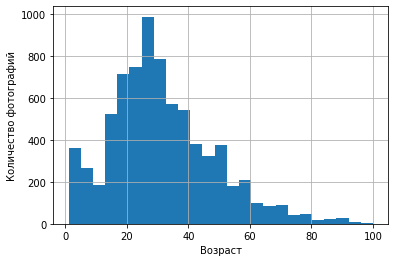

In [4]:
labels['real_age'].hist(bins = 25)
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

Видно, что возраст варьирует от 0 до 100 лет, посмотрим на количественные характеристики распределения. Пик приходится на 25-30 лет, есть провал в районе 10 лет, что будет отражаться на способностях модели.

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Как видно, минимальный возраст - 1 год, максимальный - 100 лет, в целом распределение довольно адекватно со снижением количества людей, возраста 40 и выше 

Получим объект, у которого пары «картинки — метки» с помощью функции next()

In [6]:
features_train, target_train = next(gen_flow) 

Получим размер батча и изображений в нем

In [7]:
print(features_train.shape)

(16, 224, 224, 3)


16 картинок размерами 224 на 224 с 3 слоями.
Теперь необходимо вывести картинки на экран, выведу 12:

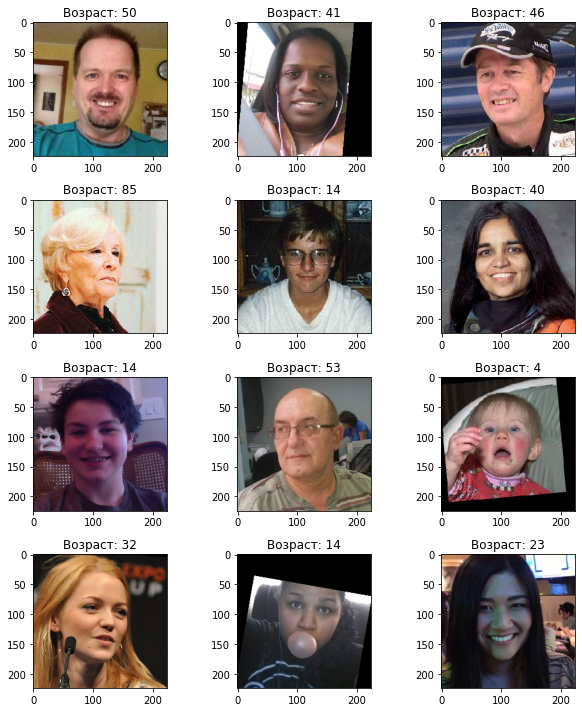

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features_train[i])
    plt.title(f'Возраст: {target_train[i]}')
    plt.tight_layout()

Видно, что на фотографиях разные люди, разных возрастов. Сами фотографии либо нормально ориентированные, либо сдвинуты/повернутые/уменьшенные. Корректность разметки не вызывает сомнений (возраст на вид совпадает с возрастом, который привязан к картинке) 

### Промежуточный итог 1
Были загружены датасет фотографий и датасет с метками к ним. Возраст людей варьировал от 1 до 100 лет с медианой 29 лет. Выведены 12 фотографий на экран. Все представленные люди разные, разных возрастов. Также сами фотографии по-разному ориентированы в пространстве.
Видно, что распределение возрастов сдвинутов в пользу людей от 15 до 30 лет, следовательно, скорее всего, это будет отражатсья на модели (он будет завышать возраст молодых и занижать возраст старых).

## Обучение модели

Была протестирована следующая сеть:

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='validation',
                                                     seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(Dense(12, activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
 
    return model
 
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

```

Получен следующий результат

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2023-10-24 16:30:19.348777: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-24 16:30:19.635534: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 50s - loss: 262.0882 - mae: 12.3987 - val_loss: 280.9985 - val_mae: 12.8931
Epoch 2/20
356/356 - 43s - loss: 195.2493 - mae: 10.8252 - val_loss: 286.5274 - val_mae: 13.4161
Epoch 3/20
356/356 - 42s - loss: 160.5496 - mae: 9.7950 - val_loss: 247.0539 - val_mae: 11.7080
Epoch 4/20
356/356 - 41s - loss: 139.6714 - mae: 9.0889 - val_loss: 200.6085 - val_mae: 11.3130
Epoch 5/20
356/356 - 42s - loss: 112.7337 - mae: 8.1566 - val_loss: 238.7838 - val_mae: 12.9832
Epoch 6/20
356/356 - 43s - loss: 91.9514 - mae: 7.3492 - val_loss: 230.6423 - val_mae: 11.4959
Epoch 7/20
356/356 - 42s - loss: 80.7479 - mae: 6.8997 - val_loss: 179.8998 - val_mae: 10.2239
Epoch 8/20
356/356 - 41s - loss: 56.7685 - mae: 5.8630 - val_loss: 141.8656 - val_mae: 9.0908
Epoch 9/20
356/356 - 43s - loss: 42.5659 - mae: 5.0877 - val_loss: 225.6909 - val_mae: 11.5340
Epoch 10/20
356/356 - 42s - loss: 35.4589 - mae: 4.6449 - val_loss: 112.2403 - val_mae: 8.1998
Epoch 11/20
356/356 - 40s - loss: 25.2178 - mae: 3.9276 - val_loss: 108.7570 - val_mae: 7.9719
Epoch 12/20
356/356 - 43s - loss: 21.7007 - mae: 3.6314 - val_loss: 150.4918 - val_mae: 9.3797
Epoch 13/20
356/356 - 43s - loss: 20.5282 - mae: 3.5059 - val_loss: 111.7002 - val_mae: 8.0205
Epoch 14/20
356/356 - 41s - loss: 19.9605 - mae: 3.4489 - val_loss: 179.4101 - val_mae: 10.0416
Epoch 15/20
356/356 - 43s - loss: 20.4597 - mae: 3.5131 - val_loss: 116.7263 - val_mae: 8.4716
Epoch 16/20
356/356 - 43s - loss: 20.6135 - mae: 3.4936 - val_loss: 112.3014 - val_mae: 8.0222
Epoch 17/20
356/356 - 42s - loss: 18.3316 - mae: 3.3199 - val_loss: 140.4252 - val_mae: 9.3196
Epoch 18/20
356/356 - 41s - loss: 17.8771 - mae: 3.2568 - val_loss: 117.2819 - val_mae: 8.3920
Epoch 19/20
356/356 - 42s - loss: 16.2004 - mae: 3.1330 - val_loss: 142.6360 - val_mae: 8.9542
Epoch 20/20
356/356 - 43s - loss: 15.2441 - mae: 3.0169 - val_loss: 116.9919 - val_mae: 7.9420
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 116.9919 - mae: 7.9420
Test MAE: 7.9420


```

## Анализ обученной модели

Представленная выше модель показала неплохой результат (`MAE` < 8). Данная ошибка вполне допустима при алгоритмах рекомендации (первая задача), но, я думаю, не самая лучшая при верификации возраста (задача 2). 
В целом, модель неплохая, особенно для рекомендации товаров, но в вопросе оценки совершеннолетия, думаю, необходима либо доработка программы на детях-подростках-молодых людях, либо коллаборация с человеком.